Ep 000 | R=67.64 CVaR=65.25 C=6.69 μ=5.00  (14.0s)
Ep 010 | R=67.32 CVaR=63.63 C=7.19 μ=5.00  (14.3s)
Ep 020 | R=68.35 CVaR=64.92 C=6.06 μ=5.00  (15.6s)
Ep 030 | R=68.04 CVaR=64.07 C=5.75 μ=5.00  (15.2s)
Ep 040 | R=67.30 CVaR=64.71 C=7.50 μ=5.00  (14.1s)
Ep 050 | R=67.98 CVaR=64.12 C=6.31 μ=5.00  (14.3s)
Ep 060 | R=67.81 CVaR=65.55 C=6.06 μ=5.00  (14.4s)
Ep 070 | R=67.27 CVaR=63.54 C=5.94 μ=5.00  (14.0s)
Ep 080 | R=67.60 CVaR=63.95 C=6.44 μ=5.00  (15.4s)
Ep 090 | R=67.86 CVaR=65.67 C=6.31 μ=5.00  (14.0s)
Ep 100 | R=68.39 CVaR=66.57 C=6.25 μ=5.00  (14.7s)
Ep 110 | R=68.17 CVaR=66.13 C=5.81 μ=5.00  (14.3s)
Ep 120 | R=67.97 CVaR=64.41 C=6.31 μ=5.00  (14.2s)


Exception ignored in: <function AsyncVectorEnv.__del__ at 0x74b30024acb0>
Traceback (most recent call last):
  File "/home/personooo/.local/lib/python3.10/site-packages/gymnasium/vector/async_vector_env.py", line 716, in __del__
    self.close(terminate=True)
  File "/home/personooo/.local/lib/python3.10/site-packages/gymnasium/vector/vector_env.py", line 234, in close
    self.close_extras(**kwargs)
  File "/home/personooo/.local/lib/python3.10/site-packages/gymnasium/vector/async_vector_env.py", line 618, in close_extras
    if process.is_alive():
  File "/home/personooo/miniconda3/envs/torch-gpu/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function AsyncVectorEnv.__del__ at 0x74b30024acb0>
Traceback (most recent call last):
  File "/home/personooo/.local/lib/python3.10/site-packages/gymnasium/vector/async_vector_env.py"

Ep 130 | R=68.01 CVaR=64.29 C=6.25 μ=5.00  (14.1s)
Ep 140 | R=67.40 CVaR=65.05 C=6.69 μ=5.00  (14.0s)
Ep 150 | R=67.57 CVaR=64.38 C=6.94 μ=5.00  (14.2s)
Ep 160 | R=67.82 CVaR=66.33 C=4.81 μ=5.00  (14.1s)
Ep 170 | R=67.69 CVaR=61.02 C=6.50 μ=5.00  (14.1s)
Ep 180 | R=68.52 CVaR=65.37 C=5.75 μ=5.00  (14.2s)
Ep 190 | R=67.76 CVaR=64.05 C=5.75 μ=5.00  (14.1s)
Ep 200 | R=68.27 CVaR=66.59 C=5.81 μ=5.00  (14.2s)
Ep 210 | R=67.82 CVaR=63.27 C=6.25 μ=5.00  (14.4s)
Ep 220 | R=67.64 CVaR=64.34 C=7.25 μ=5.00  (14.5s)
Ep 230 | R=67.92 CVaR=61.83 C=6.31 μ=5.00  (14.1s)
Ep 240 | R=68.92 CVaR=65.85 C=4.56 μ=5.00  (14.8s)
Ep 250 | R=68.58 CVaR=64.39 C=6.19 μ=5.00  (14.2s)
Ep 260 | R=67.74 CVaR=65.65 C=6.50 μ=5.00  (14.2s)
Ep 270 | R=67.90 CVaR=65.16 C=6.69 μ=5.00  (14.6s)
Ep 280 | R=67.82 CVaR=65.42 C=7.06 μ=5.00  (14.6s)
Ep 290 | R=68.26 CVaR=66.26 C=5.38 μ=5.00  (14.1s)
Ep 300 | R=67.71 CVaR=65.24 C=6.50 μ=5.00  (14.5s)
Ep 310 | R=68.06 CVaR=66.15 C=5.88 μ=5.00  (14.3s)
Ep 320 | R=67.91 CVaR=65.37 C=6

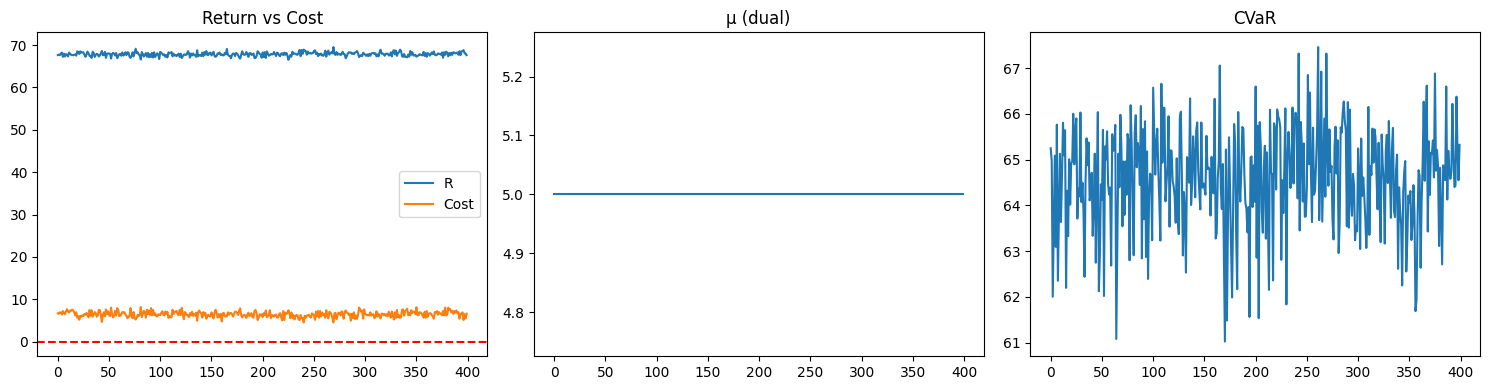

In [7]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0, etc.
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

# 1) Hyperparameters
env_id       = "roundabout-v0"
batch_size   = 16
max_steps    = 200
hidden_size  = 64
gamma        = 0.99
alpha        = 0.05
cost_limit   = 0.05
lr_policy    = 3e-4
lr_dual      = 1e-3
entropy_coef = 0.01
num_epochs   = 400

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Policy Network
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=hidden_size):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.logits(h)

# 3) Build vectorized env
def make_env(): 
    return gym.make(env_id)
envs = AsyncVectorEnv([make_env for _ in range(batch_size)])

# 4) Instantiate policy + optimizers
obs_dim    = int(np.prod(envs.single_observation_space.shape))
action_dim = envs.single_action_space.n

policy      = PolicyNet(obs_dim, action_dim).to(device)
opt_pol     = torch.optim.Adam(policy.parameters(), lr=lr_policy)
lambda_cvar = torch.tensor(1.0, requires_grad=True, device=device)
mu_cost     = torch.tensor(5.0, requires_grad=True, device=device)
opt_dual    = torch.optim.Adam([lambda_cvar, mu_cost], lr=lr_dual)

# 5) CVaR helper
def static_cvar(returns, α):
    sorted_r, _ = returns.sort()
    k = max(1, int(α * sorted_r.numel()))
    return sorted_r[:k].mean()

# 6) Collect batch in parallel
def collect_batch(envs, policy, max_steps):
    # reset
    obs, _ = envs.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=device).reshape(batch_size, -1)

    logps_buf, rews_buf = [], []
    costs = torch.zeros(batch_size, device=device)

    for _ in range(max_steps):
        logits = policy(obs)
        dist   = torch.distributions.Categorical(logits=logits)
        acts   = dist.sample()
        logps  = dist.log_prob(acts)

        step_out = envs.step(acts.cpu().numpy())
        # gymnasium: (obs, rew, term, trunc, infos)
        # gym:      (obs, rew, done, infos)
        if len(step_out) == 5:
            next_obs, rews, dones, truncs, infos = step_out
        else:
            next_obs, rews, dones, infos = step_out
            truncs = [False]*batch_size

        # ----- FIXED crash cost extraction -----
        # if infos is a single dict of arrays:
        if isinstance(infos, dict) and not isinstance(infos, list):
            # expect infos["crashed"] is array of shape (batch_size,)
            crashed_arr = infos.get("crashed", np.zeros(batch_size))
            cost_np = np.array(crashed_arr, dtype=float)
        else:
            # list of per-env dicts:
            cost_np = np.array([float(info.get("crashed", 0.0)) for info in infos], dtype=float)

        costs += torch.tensor(cost_np, device=device)

        logps_buf.append(logps)
        rews_buf.append(torch.tensor(rews, device=device))

        obs = torch.tensor(next_obs, dtype=torch.float32, device=device).reshape(batch_size, -1)
        if all(dones): 
            break

    # build discounted returns
    T = len(rews_buf)
    returns = torch.zeros(T, batch_size, device=device)
    G = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews_buf[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]
    all_logps = torch.cat(logps_buf)
    all_rets  = returns.flatten()
    return ep_R, costs, all_logps, all_rets

# 7) Single train epoch
def train_epoch(envs, policy):
    ep_R, ep_C, logps, rets = collect_batch(envs, policy, max_steps)
    cvar     = static_cvar(ep_R, alpha)
    avg_cost = ep_C.mean()

    baseline = rets.mean().detach()
    adv      = rets - baseline
    loss_surr= - (logps * adv).mean() - entropy_coef * 0.0  # add entropy if desired

    L = loss_surr - lambda_cvar * cvar + mu_cost * (avg_cost - cost_limit)
    opt_pol.zero_grad(); L.backward(retain_graph=True); opt_pol.step()

    if avg_cost > cost_limit:
        opt_dual.zero_grad()
        dual_loss = - mu_cost * (avg_cost - cost_limit)
        dual_loss.backward()
        opt_dual.step()
        mu_cost.data.clamp_(0.0, 5.0)

    return ep_R.mean().item(), cvar.item(), avg_cost.item(), mu_cost.item()

# 8) Main loop + timing
logs = []
t_start = time.time()
for ep in range(num_epochs):
    t0 = time.time()
    R, CVaR, C, mu = train_epoch(envs, policy)
    dt = time.time() - t0
    logs.append((R, CVaR, C, mu, dt))
    if ep % 10 == 0:
        print(f"Ep {ep:03d} | R={R:.2f} CVaR={CVaR:.2f} C={C:.2f} μ={mu:.2f}  ({dt:.1f}s)")

print("Total time:", time.time() - t_start)

# 9) Plot results
import pandas as pd
df = pd.DataFrame(logs, columns=["R","CVaR","Cost","μ","sec"])
fig,ax = plt.subplots(1,3,figsize=(15,4))
df[["R","Cost"]].plot(ax=ax[0]); ax[0].axhline(cost_limit, ls='--', color='r'); ax[0].set_title("Return vs Cost")
df["μ"].plot(ax=ax[1]); ax[1].set_title("μ (dual)")
df["CVaR"].plot(ax=ax[2]); ax[2].set_title("CVaR")
plt.tight_layout()
plt.show()


In [8]:
torch.save(policy.state_dict(), "Worst_Case.pt")


In [9]:
import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
import torch
import os
from IPython.display import Video, display
from pathlib import Path

# Setup
env_id = "roundabout-v0"
video_dir = "./worst"
os.makedirs(video_dir, exist_ok=True)

# Config
num_episodes = 5
max_steps = 50

# Assumes these are defined:
# - device: torch device (e.g., torch.device("cuda" or "cpu"))
# - policy: your trained policy model with .get_dist() method

for episode in range(num_episodes):
    print(f"Running episode {episode + 1}...")
    
    env = gym.make(env_id, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_dir, episode_trigger=lambda e: True)

    obs, _ = env.reset()
    policy.eval()

    for _ in range(max_steps):
        s = torch.tensor(obs, dtype=torch.float32, device=device).flatten()
        dist = policy.get_dist(s)
        action = dist.probs.argmax().item()

        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

    env.close()

print("All episodes completed.\n")

# Display all 5 recorded videos
print("Displaying all 5 recorded episodes:")
video_files = sorted(Path(video_dir).glob("*.mp4"), key=os.path.getmtime)[-num_episodes:]

for i, video_path in enumerate(video_files, 1):
    print(f"Episode {i}:")
    display(Video(str(video_path)))


Running episode 1...


/home/personooo/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/personooo/Desktop/Code/ml final/real attempt/worst folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


AttributeError: 'PolicyNet' object has no attribute 'get_dist'